<a href="https://www.kaggle.com/code/ksenia5/comparison-of-supervised-ml-spam-detection?scriptVersionId=111266733" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Comparison of supervised machine learning classifiers for spam detection

<br/>

The performance of the three ML models for classifying email text data as spam are compared:

1. **Support Vector Machine (SVM)**

1. **Naive Bayes - Multinomial and Complement**

1. **Random Forest**


These models were selected as they are good for classifying text data.


Spam email data was split into training and testing subsets in 0.75 to 0. 25 ratio. 


For each model the split, train and test cycle are repeated 100 times, logging the accuracy, and reporting its mean and standard deviation (S.D.).

#### **Libraries**

First, importing the libraries.

In [1]:
import os 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import wordcloud

# ML learning model selection, metrics, feature extraction
from sklearn import ensemble, feature_extraction, model_selection, naive_bayes, metrics, svm

# To see available files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spam-email-data/spam.csv


#### **Getting and cleaning data**

Next, reading in data, looking at the variables, and removing unwanted columns.

In [2]:
# Read into dataframe
file_path = '../input/spam-email-data/spam.csv'
data = pd.read_csv(file_path)

# Drop extra columns; use data.columns to see column names
#data = data.drop(data.columns[2:], axis=1)
data.head(n=8) # Look at data, equivalent to data.iloc[:n]
# print(data.shape)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN


#### **Exploring data**

Next, checking the proportion of spam and non-spam emails in the dataset. 

Total count is 5572 

Spam fraction = 747 / 5572 = 0.134 

Ham fraction = 4825 / 5572 = 0.866 




<function matplotlib.pyplot.show(close=None, block=None)>

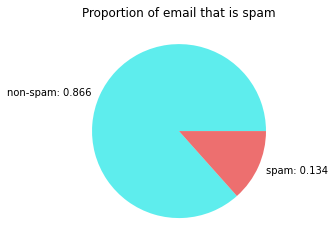

In [3]:
# Calculate spam ratio, to understand proportion of dataset that is spam:
spam_count = sum(True for entry in data.v1 if entry == 'spam')
ham_count = sum(True for entry in data.v1 if entry == 'ham')
spam_f = spam_count/len(data.v1)
ham_f = ham_count/len(data.v1)

print('Total count is {} \n'.format(spam_count+ham_count))
print('Spam fraction = {} / {} = {:.3f} \n\nHam fraction = {} / {} = {:.3f} \n\n'.format(spam_count,len(data.v1),spam_f, ham_count,len(data.v1),ham_f))

# Plot pie chart of spam and ham
colors = [(0.1, 0.9, 0.9, 0.7),(0.9, 0.2, 0.2, 0.7)]
plt.pie([ham_count,spam_count],  labels = ['non-spam: {:.3f}'.format(ham_f),'spam: {:.3f}'.format(spam_f)], colors = colors)
plt.title("Proportion of email that is spam")
plt.show

# Examine content of columns

# Check for Na/NaN 

# Check for duplicates

### Generate word clouds 
See common words in spam / non-spam emails

In [4]:
# Select only spam emails and make one string with all spam contents
spam_only = data.v2[data.v1 == 'spam']
spam_text = " ".join(email for email in spam_only)

# similarly for non-spam
ham_only = data.v2[data.v1 == 'ham']
ham_text = " ".join(email for email in ham_only)

# spam_text[:1000]
# ham_text[:1000]

# Create word clouds for spam and ham texts using the .generate() method from wordcloud.WordCloud
spam_cloud = wordcloud.WordCloud(collocations = False, background_color = 'white',
                        width = 2048, height = 1080).generate(spam_text)
ham_cloud = wordcloud.WordCloud(collocations = False, background_color = 'white',
                        width = 2048, height = 1080).generate(ham_text)
# saving the image
spam_cloud.to_file('got_spam.png')
ham_cloud.to_file('got_ham.png')

Text(0.5, 0.98, 'Common words in spam and non-spam emails')

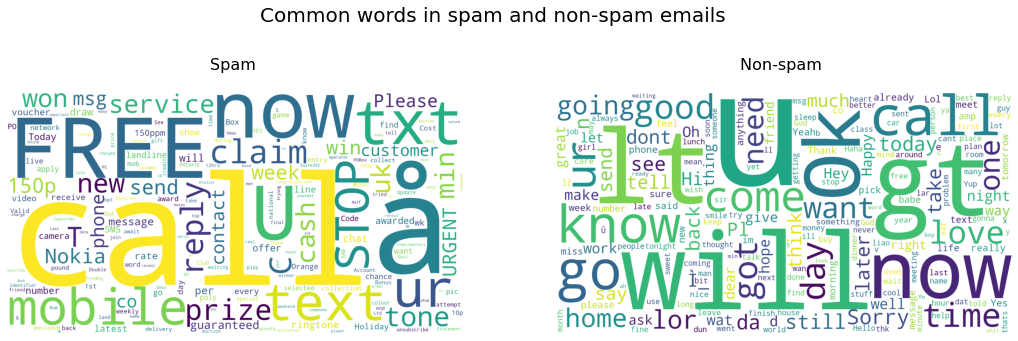

In [5]:
# figure size in inches optional
mpl.rcParams['figure.figsize'] = 18,6

# display two word clouds side by side 
fig, ax = plt.subplots(1,2, constrained_layout=False, sharey=True)

ax[0].set_title('Spam \n',fontsize=16)
ax[0].imshow(spam_cloud)
ax[0].axis('off') # turn off axes
# ax[0].set_xlabel('Spam \n',fontsize=16)
ax[1].set_title('Non-spam \n', fontsize=16)
ax[1].imshow(ham_cloud)
ax[1].axis('off')
fig.suptitle('Common words in spam and non-spam emails', fontsize= 20)

### Set the prediction features and target

* Prediction feature - email content -  independent variable

* Prediction target - *spam* or *ham* label - dependent variable

In [6]:
# Set prediction target and feature variable
X = data.v2 # Email text is the feature used in prediction
y = data.v1 # Spam/ ham classification - prediciton target

## Support Vector Machine (SVM)

The SVM classification algorithm is applied as outlined in  [this tutorial](https://blog.logrocket.com/email-spam-detector-python-machine-learning/), using the same data.

First, the data is split into training (fitting) and testing subsets, the SVM model is created and trained, and finally tested in its ability to correctly identify spam in unseen data. 

This procedure is repeated and logged to calculate mean and S.D. of prediction accuaracy.

In [7]:
# Record time to measure model runtime
start_time = time.time()
# List to log accuracy of N runs
accuracy_log = []
N = 40
for i in range(N):
    # Split data into train and test sets
    X_train, X_test,y_train, y_test = model_selection.train_test_split(X,y,test_size = 0.25)

    # Feature extraction
    cv = feature_extraction.text.CountVectorizer()
    features = cv.fit_transform(X_train)

    # Create and train SVM model
    model = svm.SVC()
    model.fit(features,y_train)
    #print('SVM Model fitted')

    features_test = cv.transform(X_test)
    accuracy_log.append(model.score(features_test,y_test))

# Log SVM model runtime
execution_time_svm = (time.time() - start_time)


# Calculate meand and SD of prediction accuracy for SVM model
svm_mean = np.mean(accuracy_log)
svm_sd = np.std(accuracy_log)

print( '\n')
print(accuracy_log)
print( '\n')
print("Data split for SVM train and test {} times.".format(N))
print( '\n')
print('Execution time in seconds: ' + str(round(execution_time_svm,1)))
print( '\n')
print("Accuracy mean and S.D  are {:.3f} and {:.3f} ".format(svm_mean, svm_sd))



[0.9806173725771715, 0.9784637473079684, 0.9834888729361091, 0.9784637473079684, 0.9842067480258435, 0.9806173725771715, 0.9770279971284996, 0.9798994974874372, 0.9777458722182341, 0.9827709978463748, 0.9806173725771715, 0.9784637473079684, 0.9820531227566404, 0.9791816223977028, 0.9763101220387652, 0.9885139985642498, 0.9813352476669059, 0.9885139985642498, 0.9777458722182341, 0.9820531227566404, 0.9820531227566404, 0.9784637473079684, 0.9856424982053122, 0.9777458722182341, 0.9727207465900933, 0.9820531227566404, 0.9763101220387652, 0.9777458722182341, 0.9806173725771715, 0.9798994974874372, 0.9820531227566404, 0.9748743718592965, 0.9748743718592965, 0.9770279971284996, 0.9777458722182341, 0.9798994974874372, 0.9784637473079684, 0.9820531227566404, 0.9777458722182341, 0.9777458722182341]


Data split for SVM train and test 40 times.


Execution time in seconds: 64.3


Accuracy mean and S.D  are 0.980 and 0.003 


#### Questions on SVM:

* Can I see the **support vectors** to help with **model explainability, contextualisation and visualisation**

* Margins - hard/ soft - how to define

## Naive Bayes

The **Naive Bayes** classifier is a **simple probabilistic ML classification model**. Based on statistical classfication using the Bayes Theorem, it assumes no dependence between features used in prediction, and works best when this is true.




### Mutlinomial Naive Bayes (MNB) 

The MNB is often used to classify and categorise text according to word frequency, and is suited to classifying email as spam.

In [8]:
start_time = time.time() # Record time to measure model runtime

mnb_log = [] # log accuracy of each split
N = 40 # number splits
for i in range(N):
    # Split data into train and test sets
    X_train, X_test,y_train, y_test = model_selection.train_test_split(X,y,test_size = 0.25)

    # Feature extraction
    cv = feature_extraction.text.CountVectorizer()
    features = cv.fit_transform(X_train)

    # Fit MNB model
    model_mnb = naive_bayes.MultinomialNB()
    model_mnb.fit(features, y_train)
    
    # Test model
    features_test = cv.transform(X_test)
    mnb_log.append(model_mnb.score(features_test,y_test))

# Log MNB model runtime
execution_time_mnb = (time.time() - start_time)


mnb_mean = np.mean(mnb_log)
mnb_sd = np.std(mnb_log)
print( '\n')
print("Data split for multinomial NB train and test {} times.".format(N))
print( '\n')
print("Accuracy mean and S.D  are {:.3f} and {:.3f} ".format(mnb_mean, mnb_sd))
print( '\n')
print('Execution time in seconds: ' + str(round(execution_time_mnb,1)))



Data split for multinomial NB train and test 40 times.


Accuracy mean and S.D  are 0.986 and 0.003 


Execution time in seconds: 4.7


### Complement Naive Bayes (CNB)

CNB is a variation of the MNB model that is particularly suited for imbalanced data sets, see the [Sklearn ref ](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB)

In [9]:
start_time = time.time() # Record time to measure model runtime

N = 40 # Number of cycles
cnb_log = [] # log accuracy of N cycles

for i in range(N):
    # Split data into train and test sets
    X_train, X_test,y_train, y_test = model_selection.train_test_split(X,y,test_size = 0.25)

    # Feature extraction
    cv = feature_extraction.text.CountVectorizer()
    features = cv.fit_transform(X_train)

    # Fit model
    model_cnb = naive_bayes.ComplementNB()
    model_cnb.fit(features, y_train)
    
    # Test model
    features_test = cv.transform(X_test)
    cnb_log.append(model_cnb.score(features_test,y_test))

# Log CNB model runtime
execution_time_cnb = (time.time() - start_time)
    
cnb_mean = np.mean(cnb_log)
cnb_sd = np.std(cnb_log)

print( '\n')
print("Data split for complement NB train and test {} times.".format(N))
print( '\n')
print("Accuracy mean and S.D  are {:.3f} and {:.3f} ".format(cnb_mean, cnb_sd))
print( '\n')
print('CNB execution time in seconds: ' + str(round(execution_time_cnb,1)))



Data split for complement NB train and test 40 times.


Accuracy mean and S.D  are 0.979 and 0.003 


CNB execution time in seconds: 4.5


## Random Forest

The [RF classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) is another supervised ML model suited to text classification based on word frequency occurence in text.

In [10]:
start_time = time.time() # Record time to measure model runtime

N = 40 # Number cycles
rf_log = [] # Log accuracy N cycles


for i in range(N):
    # As before, split data into train and test sets
    X_train, X_test,y_train, y_test = model_selection.train_test_split(X,y,test_size = 0.25)

    # Feature extraction
    cv = feature_extraction.text.CountVectorizer()
    features = cv.fit_transform(X_train)

    # create and train Random Forest Model
    forest_model = ensemble.RandomForestClassifier(random_state=1)
    forest_model.fit(features, y_train) # Sample weight ???

    # Test model
    features_test = cv.transform(X_test)
    rf_log.append(forest_model.score(features_test,y_test))

# Log RFmodel runtime
execution_time_rf = (time.time() - start_time)

rf_mean = np.mean(rf_log)
rf_sd = np.std(rf_log)
print("\n")
print("Data split for Random Forest train and test {} times.".format(N))
print("\n")
print("Accuracy mean and S.D  are {:.3f} and {:.3f} ".format(rf_mean, rf_sd))
print( '\n')
print('RF execution time in seconds: ' + str(round(execution_time_rf,1)))



Data split for Random Forest train and test 40 times.


Accuracy mean and S.D  are 0.975 and 0.004 


RF execution time in seconds: 45.9


## Compare model performance - accuracy and runtime

Accuracy mean and SD for SVM, MNB, CNB and RF collected into table and plotted.

In [11]:
accuracy_data = {'Model': ['Support Vector Machine', 'Multinomial Naive Bayes', 'Complement Naive Bayes', 'Random Forest'], 'Mean Accuracy': [svm_mean, mnb_mean, cnb_mean, rf_mean], 'SD': [svm_sd, mnb_sd, cnb_sd, rf_sd],'Runtime (s)': [execution_time_svm/N, execution_time_mnb/N, execution_time_cnb/N, execution_time_rf/N]}

accuracy_df = pd.DataFrame(data=accuracy_data)
print("\n")
print("Comparison of the accuracy mean and SD for 100 cycles split-train-test")
print("\n")
accuracy_df.round(3)



Comparison of the accuracy mean and SD for 100 cycles split-train-test




,Model,Mean Accuracy,SD,Runtime (s)
0,Support Vector Machine,0.980,0.003,1.608
1,Multinomial Naive Bayes,0.986,0.003,0.117
2,Complement Naive Bayes,0.979,0.003,0.113
3,Random Forest,0.975,0.004,1.148


# (+) Compare model performance with another dataset


# (+) Process text data to extract numerical data, e.g.

* Email length
* Link
* White space
* Punctuation
* Word count
* Word length
* Attachment

## References

* Log rocket [tutorial on SVM for spam detection](https://blog.logrocket.com/email-spam-detector-python-machine-learning/)
* Add ref for model selection
* Add ref word clouds